Here we will plot some solutions to the problem we analyzed last week
$$u'\left(c_t\right) = \beta \left(1+r\right) u'\left(c_{t+1}\right)$$

In [1]:
using Plots 
using Distributions
using Parameters



In [36]:
Household = @with_kw (r = 0.03,                 
                      σ = 1.0,
                      β = 0.97,
                      T = 40,
                      y = ones(T+1,1),
                      a0 = 0.0,
                      u = σ == 1 ? x -> log(x) : x -> (x^(1 - σ) - 1) / (1 - σ)
					  )

##NamedTuple_kw#316 (generic function with 2 methods)

In [48]:
# create some functions

function get_lifetime_income!(hh)
    human_wealth     = 0 
    for i in hh.T+1:-1:1
        human_wealth = human_wealth / (1+hh.r) + hh.y[i,1]
    end
    financial_wealth = (1+hh.r) * hh.a0 

    wealth = (H = human_wealth, fin = financial_wealth)
    hh = merge(hh,wealth)
end


function get_solution!(hh)
    mpc_0 = 0
    c_ratio         = zeros(hh.T+1,1)
    c_opt           = zeros(hh.T+1,1)
    s_opt           = zeros(hh.T+1,1)
    intertemp_price = zeros(hh.T+1,1)
    for i in 1:hh.T+1
        c_ratio[i,1] = ((1 + hh.r) * hh.β) ^ ((1/hh.σ) * (i-1))
        
        intertemp_price[i,1] = (1/(1+hh.r)) ^ ((i-1))
    end

    mpc_0 = 1 / (sum(c_ratio.* intertemp_price))
    c_opt[:] .= mpc_0 .* (hh.H .+ hh.fin) .* c_ratio
    s_opt[1]  = hh.y[1] + (1+hh.r) * hh.a0 - c_opt[1]
    for i in 2:hh.T+1
        s_opt[i]  = hh.y[i] + (1+hh.r) * s_opt[i-1] - c_opt[i]
    end
    sol = (c = c_opt, s = s_opt, s_rate = 1 .- c_opt./hh.y)
    return hh_new = merge(hh,sol)
end


get_solution! (generic function with 1 method)

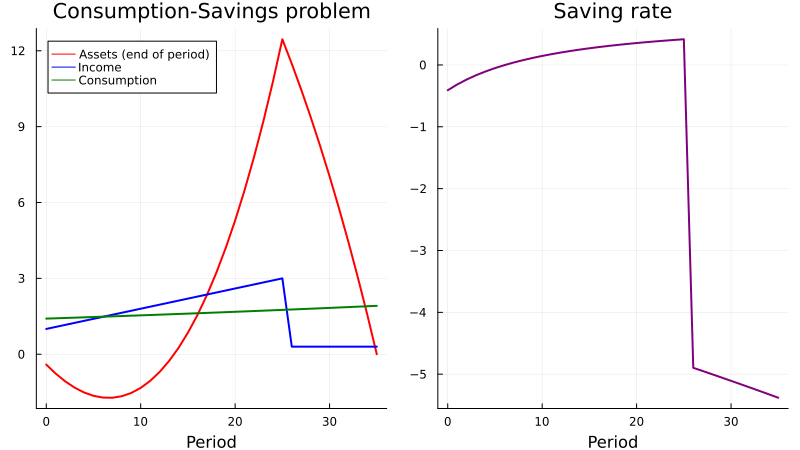

In [75]:
ret_age = 25
replacement = 0.1

T = 35

y_level = 1
y_peak  = 3
y_path  = zeros(T+1,)
y_path[1:ret_age+1,1]  = y_level * ones(ret_age+1,1) + LinRange(0,(y_peak-1),ret_age+1)
y_path[ret_age+2:end,1] .= replacement * y_path[ret_age+1,1]

hh_1    = Household(T=T,y=y_path,r = 0.04)
hh_1    = get_lifetime_income!(hh_1)
hh_1    = get_solution!(hh_1)

paths_plot = plot([0:hh_1.T],hh_1.s,color = :red,lw=2  ,labels="Assets (end of period)")
plot!(paths_plot, [0:hh_1.T],hh_1.y,color = :blue,lw=2 ,labels="Income")
plot!(paths_plot, [0:hh_1.T],hh_1.c,color = :green,lw=2,labels="Consumption")
plot!(paths_plot,xlabel="Period",title="Consumption-Savings problem",legend = :topleft)

paths_plot2 = plot([0:hh_1.T],hh_1.s_rate,color = :purple,lw=2  ,labels="Savings rate")
plot!(paths_plot2,xlabel="Period",title="Saving rate",legend = false)

plot(paths_plot,paths_plot2,layout=(1,2),size=(800,450))
